This notebook trains models using clean and noisy audio files.

It uses the models from the paper "Sub-mW Keyword Spotting on an MCU: Analog Binary Feature Extration and Bynary Neural Networks" by Cerutti et al. (2022) published on IEEE Transactions on Circuits and Systems.

The first three models are here trained and tested: 
- Baseline (full precision model).
- Binary weights.
- BNN (binary weights and binary activations).

The goals are:
1) Find models trained with noisy data that reaches the same performance that original models trained with noiseless data (original data).
2) Evaluate the models with different SNR values (0dB, 5dB, 10dB, 15dB, 20dB) and different real noise types.
3) Determine if models trained with noise reach better performance than models trained without noise.

In [6]:
from spectrogram import SpectrogramSpeechCommandDataset
from speech_command_dataset import SpeechCommandDataset
import matplotlib.pyplot as plt
import torch, torchaudio
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torchModel import train_model, test_model_with_confusion_matrix
from ModelsArchitecture import BinarizedInputNetwork, ConvNet , BinarizedWeightNetwork

seed = 42

# Load noiseless data

In [7]:
DATASET_PATH = '/home/luciano/Downloads/speech_commands_v0.02/'
TESTSET_PATH = '/home/luciano/Downloads/speech_commands_test_set_v0.02/'

KEYWORDS =  list(set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] + ['unknown', 'silence']))

# Check for GPU availability and use it if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


SAMPLE_RATE = 16000
N_MELS = 64
N_FFT = 512
POWER = 2.0
F_MIN = 50.0
F_MAX = 7500.0
HOP_LENGTH=round(SAMPLE_RATE*0.01)
WIN_LENGTH=round(SAMPLE_RATE*0.025)
DURATION_SEC = 1.0

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            n_mels=N_MELS,
            n_fft=N_FFT, 
            hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH,
            f_min=F_MIN,
            f_max=F_MAX,
            power=POWER,
            sample_rate=SAMPLE_RATE,
        )

dataset = SpectrogramSpeechCommandDataset(
    audio_dataset_path=DATASET_PATH,
    audio_test_path=TESTSET_PATH,
    transformation=mel_spectrogram,
    sample_rate= SAMPLE_RATE,
    duration_seconds = DURATION_SEC,
    keywords=KEYWORDS,
    device = device
)

Using device: cuda


## Load audio files

In [8]:
test_set_waveform = dataset.get_testset()
validation_set_waveform = dataset.get_validationset()
train_set_waveform = dataset.get_trainset()

# MEL Spectrogram

In [9]:
test_set = dataset.get_spectrum_testset()
train_set = dataset.get_spectrum_trainset()
validation_set = dataset.get_spectrum_validationset()

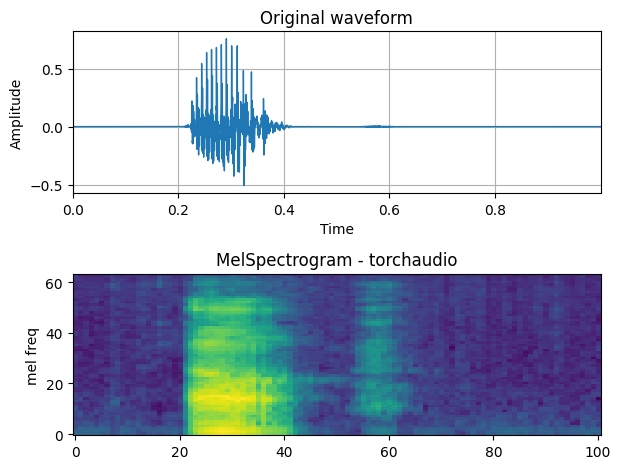

In [10]:
def plot_waveform(waveform, sr, xlabel,ylabel,title="Waveform", ax=None,):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow((specgram), origin="lower", aspect="auto", interpolation="nearest")


fig, axs = plt.subplots(2, 1)
plot_waveform(train_set_waveform[0][0].cpu(), SAMPLE_RATE, title="Original waveform", 
              ax=axs[0],ylabel="Amplitude",xlabel="Time")
plot_spectrogram(train_set[0][0][0].cpu(), ax=axs[1],title="MelSpectrogram - torchaudio", ylabel="mel freq")
fig.tight_layout()

# train models

In [8]:
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001

# load all values in memory for faster training
def load_in_memory(data_set):
    all_data = []
    all_labels = []
    for data, label in data_set:
        all_data.append(data)
        all_labels.append(label)
    return all_data, all_labels


all_data , all_labels = load_in_memory(train_set)
train_tensor = TensorDataset(torch.stack(all_data) ,torch.tensor(all_labels) )
all_data , all_labels = load_in_memory(validation_set)
val_tensor = TensorDataset(torch.stack(all_data) ,torch.tensor(all_labels) )
all_data , all_labels = load_in_memory(test_set)
test_tensor = TensorDataset(torch.stack(all_data) ,torch.tensor(all_labels) )

train_loader = DataLoader(train_tensor, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE, shuffle=False)

## Build Full precision model

In [6]:
model = ConvNet().to(device)
summary(model,(1,101,64),batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 51, 32]             640
       BatchNorm2d-2           [16, 64, 51, 32]             128
            Conv2d-3          [16, 128, 51, 32]          73,856
       BatchNorm2d-4          [16, 128, 51, 32]             256
            Conv2d-5          [16, 128, 26, 16]         147,584
       BatchNorm2d-6          [16, 128, 26, 16]             256
            Conv2d-7          [16, 192, 26, 16]         221,376
       BatchNorm2d-8          [16, 192, 26, 16]             384
            Conv2d-9          [16, 192, 26, 16]          37,056
      BatchNorm2d-10          [16, 192, 26, 16]             384
           Conv2d-11           [16, 64, 26, 16]          12,352
      BatchNorm2d-12           [16, 64, 26, 16]             128
           Linear-13                   [16, 12]             780
Total params: 495,180
Trainable params:

Epoch 1/50, Train Loss: 1.2437, Train Acc: 0.6178, Val Loss: 0.7115, Val Acc: 0.7598, Learning Rate: 0.001000
Epoch 2/50, Train Loss: 0.4279, Train Acc: 0.8752, Val Loss: 0.3668, Val Acc: 0.8924, Learning Rate: 0.001000
Epoch 3/50, Train Loss: 0.2830, Train Acc: 0.9131, Val Loss: 0.3029, Val Acc: 0.9136, Learning Rate: 0.001000
Epoch 4/50, Train Loss: 0.2235, Train Acc: 0.9318, Val Loss: 0.2700, Val Acc: 0.9181, Learning Rate: 0.001000
Epoch 5/50, Train Loss: 0.1876, Train Acc: 0.9406, Val Loss: 0.2020, Val Acc: 0.9457, Learning Rate: 0.001000
Epoch 6/50, Train Loss: 0.1583, Train Acc: 0.9497, Val Loss: 0.1856, Val Acc: 0.9435, Learning Rate: 0.001000
Epoch 7/50, Train Loss: 0.1421, Train Acc: 0.9544, Val Loss: 0.1801, Val Acc: 0.9489, Learning Rate: 0.001000
Epoch 8/50, Train Loss: 0.1225, Train Acc: 0.9619, Val Loss: 0.1740, Val Acc: 0.9475, Learning Rate: 0.001000
Epoch 9/50, Train Loss: 0.1087, Train Acc: 0.9658, Val Loss: 0.1705, Val Acc: 0.9496, Learning Rate: 0.001000
Epoch 10/5

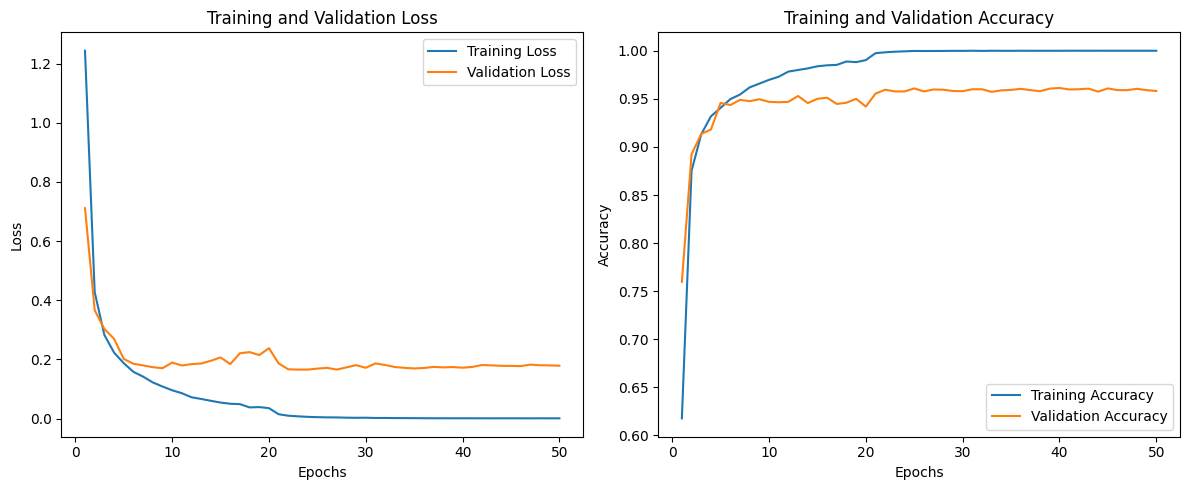

In [7]:
train_model(train_loader, val_loader, model,device,LEARNING_RATE,num_epochs=50)
torch.save(model.state_dict(), "full_precision.pth")

Test Accuracy: 0.9640


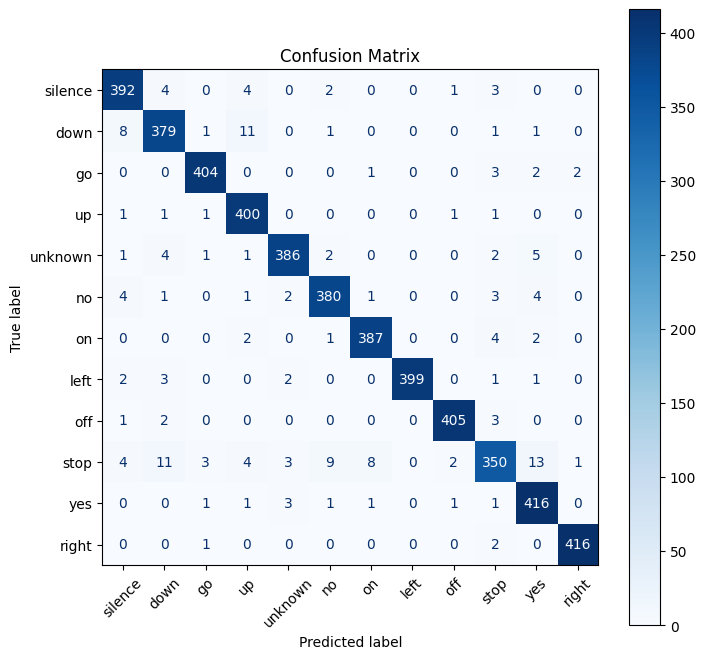

In [8]:
test_model_with_confusion_matrix(test_loader,model,KEYWORDS,device)

## Build BWN model

In [20]:
input_shape = (1, 64, 101)  # Example input shape, adjust as needed
num_classes = len(KEYWORDS)  # Example number of classes, adjust as needed
model = BinarizedWeightNetwork(input_shape, num_classes).to(device)

In [22]:
summary(model,(1,101,64),batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 51, 32]             640
       BatchNorm2d-2           [16, 64, 51, 32]             128
_BinarizedWeightConv2D-3          [16, 128, 51, 32]               0
       BatchNorm2d-4          [16, 128, 51, 32]             256
_BinarizedWeightConv2D-5          [16, 128, 26, 16]               0
       BatchNorm2d-6          [16, 128, 26, 16]             256
_BinarizedWeightConv2D-7          [16, 192, 26, 16]               0
       BatchNorm2d-8          [16, 192, 26, 16]             384
_BinarizedWeightConv2D-9          [16, 192, 26, 16]               0
      BatchNorm2d-10          [16, 192, 26, 16]             384
           Conv2d-11           [16, 12, 26, 16]           2,316
AdaptiveAvgPool2d-12             [16, 12, 1, 1]               0
           Linear-13                   [16, 12]             156
Total params: 4,520
Tra

Epoch 1/50, Train Loss: 2.2852, Train Acc: 0.3327, Val Loss: 2.1731, Val Acc: 0.4557, Learning Rate: 0.001000
Epoch 2/50, Train Loss: 2.0361, Train Acc: 0.6005, Val Loss: 2.0035, Val Acc: 0.6256, Learning Rate: 0.001000
Epoch 3/50, Train Loss: 1.8923, Train Acc: 0.7436, Val Loss: 1.8123, Val Acc: 0.8165, Learning Rate: 0.001000
Epoch 4/50, Train Loss: 1.8363, Train Acc: 0.7930, Val Loss: 1.8951, Val Acc: 0.7276, Learning Rate: 0.001000
Epoch 5/50, Train Loss: 1.8028, Train Acc: 0.8252, Val Loss: 1.7606, Val Acc: 0.8685, Learning Rate: 0.001000
Epoch 6/50, Train Loss: 1.7761, Train Acc: 0.8499, Val Loss: 1.7533, Val Acc: 0.8703, Learning Rate: 0.001000
Epoch 7/50, Train Loss: 1.7570, Train Acc: 0.8690, Val Loss: 1.7349, Val Acc: 0.8904, Learning Rate: 0.001000
Epoch 8/50, Train Loss: 1.7450, Train Acc: 0.8801, Val Loss: 1.7252, Val Acc: 0.8989, Learning Rate: 0.001000
Epoch 9/50, Train Loss: 1.7331, Train Acc: 0.8909, Val Loss: 1.7601, Val Acc: 0.8627, Learning Rate: 0.001000
Epoch 10/5

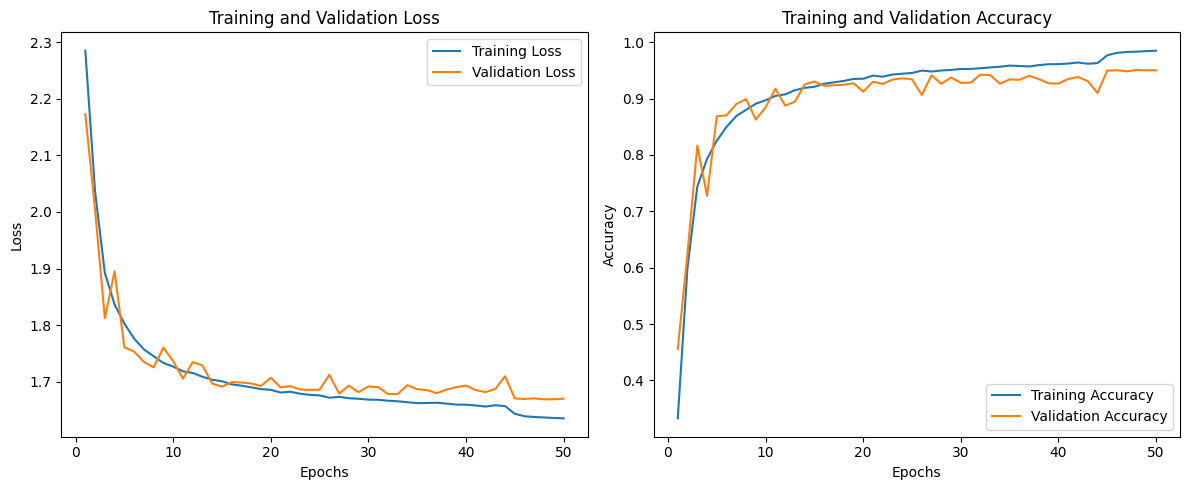

In [23]:
train_model(train_loader, val_loader, model,device,
            learning_rate=LEARNING_RATE,num_epochs=EPOCHS)

Test Accuracy: 0.9534


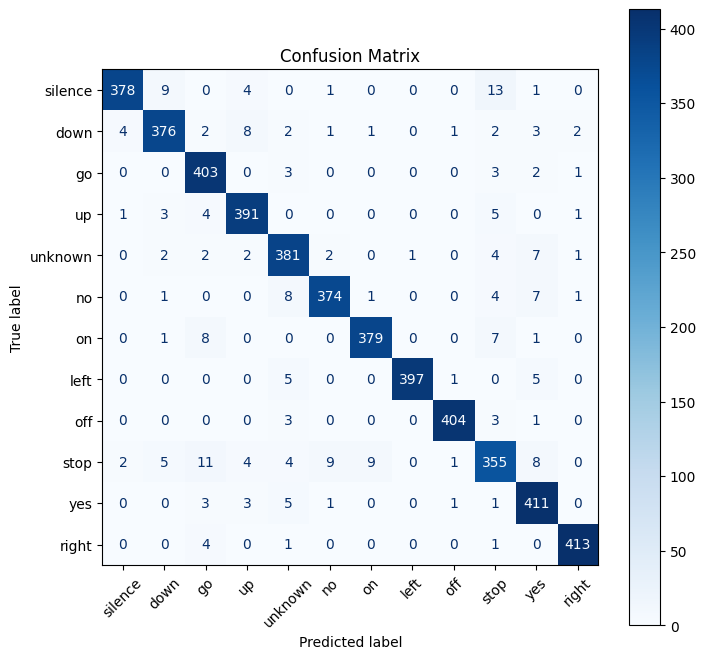

In [24]:
torch.save(model.state_dict(), "BinaryWeights.pth")
test_model_with_confusion_matrix(test_loader,model,KEYWORDS,device)

## full binary model (weights and activations)

In [25]:
input_shape = (1, 64, 101)  # Example input shape, adjust as needed
num_classes = len(KEYWORDS)  # Example number of classes, adjust as needed

model = BinarizedInputNetwork(input_shape, num_classes).to(device)
summary(model,(1,101,64),batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 51, 32]             640
       BatchNorm2d-2           [16, 64, 51, 32]             128
   _BinarizeConv2d-3          [16, 128, 51, 32]          73,728
       BatchNorm2d-4          [16, 128, 51, 32]             256
   _BinarizeConv2d-5          [16, 128, 26, 16]         147,456
       BatchNorm2d-6          [16, 128, 26, 16]             256
   _BinarizeConv2d-7          [16, 192, 26, 16]         221,184
       BatchNorm2d-8          [16, 192, 26, 16]             384
   _BinarizeConv2d-9          [16, 192, 26, 16]          36,864
      BatchNorm2d-10          [16, 192, 26, 16]             384
           Conv2d-11           [16, 12, 26, 16]           2,316
AdaptiveAvgPool2d-12             [16, 12, 1, 1]               0
           Linear-13                   [16, 12]             156
Total params: 483,752
Trainable params:

Epoch 1/50, Train Loss: 2.3935, Train Acc: 0.2047, Val Loss: 2.4507, Val Acc: 0.1571, Learning Rate: 0.001000
Epoch 2/50, Train Loss: 2.3196, Train Acc: 0.2942, Val Loss: 2.2544, Val Acc: 0.3751, Learning Rate: 0.001000
Epoch 3/50, Train Loss: 2.2030, Train Acc: 0.4199, Val Loss: 2.1334, Val Acc: 0.4842, Learning Rate: 0.001000
Epoch 4/50, Train Loss: 2.1199, Train Acc: 0.5075, Val Loss: 2.0705, Val Acc: 0.5608, Learning Rate: 0.001000
Epoch 5/50, Train Loss: 2.0434, Train Acc: 0.5842, Val Loss: 2.0140, Val Acc: 0.6083, Learning Rate: 0.001000
Epoch 6/50, Train Loss: 1.9909, Train Acc: 0.6347, Val Loss: 1.9747, Val Acc: 0.6499, Learning Rate: 0.001000
Epoch 7/50, Train Loss: 1.9296, Train Acc: 0.6982, Val Loss: 1.9225, Val Acc: 0.7044, Learning Rate: 0.001000
Epoch 8/50, Train Loss: 1.8636, Train Acc: 0.7653, Val Loss: 1.8203, Val Acc: 0.8050, Learning Rate: 0.001000
Epoch 9/50, Train Loss: 1.8360, Train Acc: 0.7907, Val Loss: 1.8783, Val Acc: 0.7447, Learning Rate: 0.001000
Epoch 10/5

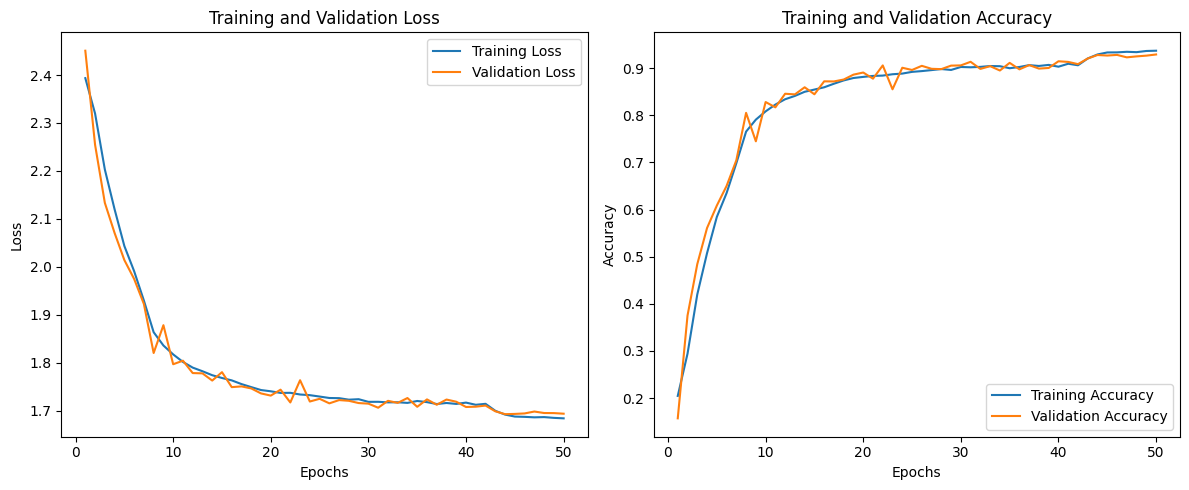

In [26]:
train_model(train_loader, val_loader, model,device,LEARNING_RATE,num_epochs=EPOCHS)
torch.save(model.state_dict(), "full_binary_model.pth")

Test Accuracy: 0.9311


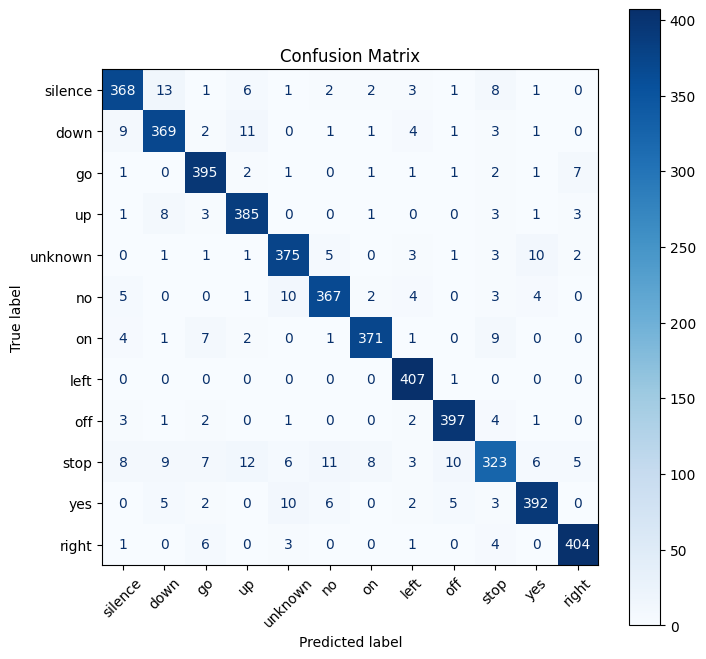

In [27]:
test_model_with_confusion_matrix(test_loader,model,KEYWORDS,device)